In [1]:
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    Trainer, 
    TrainingArguments
)
from datasets import Dataset as HFDataset
import tqdm

In [2]:
def load_dictionary(filename):
    """
    Load a dictionary from a file using pickle.
    
    Args:
        filename (str): The name of the file to load from
        
    Returns:
        dict: The loaded dictionary
    """
    with open(filename, 'rb') as file:
        dictionary = pickle.load(file)
    print(f"Dictionary loaded from {filename}")
    return dictionary

In [3]:
p2i = load_dictionary('p2i')
i2a = load_dictionary('i2a')
i2p = load_dictionary('i2p')
a2i =load_dictionary('a2i')

Dictionary loaded from p2i
Dictionary loaded from i2a
Dictionary loaded from i2p
Dictionary loaded from a2i


In [4]:
df = pd.read_csv('author_ratings_normalized.csv', lineterminator='\n')

In [5]:
# Create pessimistic target 
a = .05
b = .05
df['reward'] = df['rating_norm'] - a*df['rd_norm'] - b*df['volatility_norm']

Reward statistics:
count    246286.000000
mean          0.456940
std           0.242306
min          -0.039580
25%           0.283523
50%           0.456561
75%           0.636640
max           0.963868
Name: reward, dtype: float64


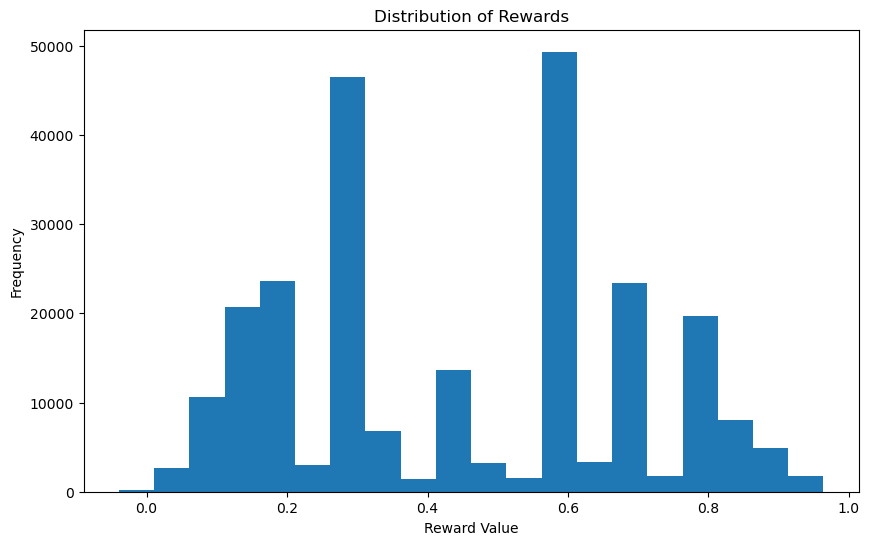

In [6]:
# Ensure column names match expected format
if "question" not in df.columns and "questions" in df.columns:
    df = df.rename(columns={"questions": "question"})
if "answer" not in df.columns and "answers" in df.columns:
    df = df.rename(columns={"answers": "answer"})
if "reward" not in df.columns and "rewards" in df.columns:
    df = df.rename(columns={"rewards": "reward"})

# Display first few rows
df.head()

# Basic statistics of the rewards
print(f"Reward statistics:\n{df['reward'].describe()}")

# Plot reward distribution
plt.figure(figsize=(10, 6))
plt.hist(df['reward'], bins=20)
plt.title('Distribution of Rewards')
plt.xlabel('Reward Value')
plt.ylabel('Frequency')
plt.show()

4. Prepare Data for Training

In [7]:
# Split data into train and validation sets
train_df, eval_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(eval_df)}")

# Convert to HuggingFace datasets
train_dataset = HFDataset.from_pandas(train_df)
eval_dataset = HFDataset.from_pandas(eval_df)

Training set size: 197028
Validation set size: 49258


5. Prepare Tokenizer and Model

In [8]:

# Load RoBERTa tokenizer and model
model_name = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(model_name)

# Initialize RoBERTa model for regression
model = RobertaForSequenceClassification.from_pretrained(
    model_name,
    num_labels=1,  # Single output for reward prediction
    problem_type="regression"
)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
# Define tokenization function
def tokenize_function(examples, max_length=64):
    questions = examples["question"]
    answers = examples["answer"]
    
    # Combine question and answer pairs
    texts = [f"Question: {q} Answer: {a}" for q, a in zip(questions, answers)]
    
    # Tokenize the texts
    tokenized = tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
    
    return tokenized
# Tokenize datasets and format them for training
def tokenize_and_format(batch):
    tokenized = tokenize_function(batch)
    batch["input_ids"] = tokenized["input_ids"]
    batch["attention_mask"] = tokenized["attention_mask"]
    return batch

In [ ]:
# Apply tokenization
tokenized_train = train_dataset.map(tokenize_and_format, batched=True)
tokenized_eval = eval_dataset.map(tokenize_and_format, batched=True)

Map:   0%|          | 0/197028 [00:00<?, ? examples/s]

6. Set up Training Arguments

In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results/roberta-reward-model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=1,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    greater_is_better=False,
    push_to_hub=False,
    disable_tqdm = False,
)

In [20]:
data_lim = 10

7. Training the Model

In [21]:
# Set up the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train[:data_lim],
    eval_dataset=tokenized_eval[:int(data_lim*.1)],
)


In [27]:
len(tokenized_train[2]['input_ids'])

512

In [22]:
# Start the training process
trainer.train()

KeyboardInterrupt: 

8. Save the Fine-tuned Model

In [ ]:
# Save the model and tokenizer
model_save_path = "./roberta-reward-model"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model saved to {model_save_path}")

9. Evaluate the Model on Test Data

In [ ]:
# Get evaluation metrics
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

10. Using the Model for Prediction

In [ ]:
# Function to predict rewards for new question-answer pairs
def predict_reward(question, answer, model, tokenizer):
    # Combine question and answer
    text = f"Question: {question} Answer: {answer}"
    
    # Tokenize
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=512
    )
    
    # Get prediction
    with torch.no_grad():
        outputs = model(**inputs)
        predicted_reward = outputs.logits.item()
    
    return predicted_reward

In [ ]:
# Try with some sample questions and answers
sample_questions = [
    "What is the capital of France?",
    "How does photosynthesis work?",
    "What is the meaning of life?"
]

sample_answers = [
    "Paris is the capital of France.",
    "Photosynthesis is the process where plants convert sunlight, water and carbon dioxide into oxygen and glucose.",
    "The meaning of life is a philosophical question that has been debated for centuries."
]

# Make predictions
for q, a in zip(sample_questions, sample_answers):
    reward = predict_reward(q, a, model, tokenizer)
    print(f"Question: {q}")
    print(f"Answer: {a}")
    print(f"Predicted reward: {reward:.4f}\n")

11. Visualize Predicted vs. Actual Rewards

In [ ]:
# Get predictions for the validation set
def get_predictions(dataset, model, tokenizer):
    predictions = []
    actual = []
    
    for i in range(len(dataset)):
        example = dataset[i]
        question = example['question']
        answer = example['answer']
        reward = example['reward']
        
        pred_reward = predict_reward(question, answer, model, tokenizer)
        predictions.append(pred_reward)
        actual.append(reward)
    
    return predictions, actual

# Sample a subset for visualization (to avoid long processing time)
sample_size = min(100, len(eval_dataset))
sampled_eval = eval_dataset.select(range(sample_size))

# Get predictions
predicted_rewards, actual_rewards = get_predictions(sampled_eval, model, tokenizer)

In [ ]:
# Plot predicted vs. actual rewards
plt.figure(figsize=(10, 6))
plt.scatter(actual_rewards, predicted_rewards, alpha=0.7)
plt.plot([min(actual_rewards), max(actual_rewards)], 
         [min(actual_rewards), max(actual_rewards)], 'r--')
plt.xlabel('Actual Rewards')
plt.ylabel('Predicted Rewards')
plt.title('Predicted vs. Actual Rewards')
plt.grid(True)
plt.show()

# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(actual_rewards, predicted_rewards)
mae = mean_absolute_error(actual_rewards, predicted_rewards)
r2 = r2_score(actual_rewards, predicted_rewards)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

In [15]:
train_df, test_df = train_test_split(
        df, 
        test_size=.2,
        random_state=42,
        stratify=None
    )
    
# Reset indices
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [17]:
test_df.describe()

,rating,deviation (RD),volatility,rating_norm,rd_norm,volatility_norm,reward
count,49258.000000,49258.000000,49258.000000,49258.000000,49258.000000,49258.000000,49258.000000
mean,1496.772728,243.866918,0.060014,0.495279,0.783676,0.016820,0.455254
std,238.490015,43.673539,0.000062,0.241556,0.203384,0.018629,0.241731
min,1008.436603,79.937647,0.059958,0.000665,0.020269,0.000000,-0.037081
25%,1296.346142,208.560340,0.060000,0.292276,0.619256,0.012564,0.271207
50%,1500.000000,253.404608,0.060000,0.498548,0.828093,0.012564,0.456561
75%,1667.529088,290.318965,0.060009,0.668231,1.000000,0.015284,0.636640
max,1992.220354,290.318965,0.062522,0.997096,1.000000,0.771326,0.963868
